# Tutorial1: data integration for Agg_BMMC data (scVI)

在聚合的BMMC数据（cells）上运行FGOT，其中cost的建立来自于多种sota的多组学整合方法。

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [3]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/BMMC_data/"
RNA_data = pd.read_csv(data_path+'RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'ATAC_normalized.txt', sep='\t', index_col=0)

In [4]:
RNA_cluster = pd.read_csv(data_path+"BMMC_RNA_label.txt", sep='\t')
ATAC_cluster = pd.read_csv(data_path+"BMMC_agg_k5_atac_label.txt", sep='\t')
RNA_cluster = RNA_cluster.reset_index()
RNA_cluster = RNA_cluster.rename(columns={'index':'cell','x': 'cluster'})
ATAC_cluster = ATAC_cluster.reset_index()
ATAC_cluster = ATAC_cluster.rename(columns={'index':'cell','metas': 'cluster'})

In [5]:
X1 = ATAC_data
X2 = RNA_data
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.index)
cell_names2 = list(RNA_data.index)
peak_names = list(ATAC_data.columns)
gene_names = list(RNA_data.columns)

Dimensions of input datasets are:  X1 =  (1602, 6970)  X2 =  (2379, 275)
Dimensions of basic_labels are:  basic_labels1 =  (1602,)  basic_labels2 =  (2379,)


## build a priori feature graph

In [6]:
promoters = pd.read_csv(data_path+'hg19.promoter.regions.txt', sep = '\t',header=None)
promoters[3] = promoters[3].str.split('|').str[0]
promoters.rename(columns={0: 'chr', 1: 'starts', 2: 'ends', 3: 'genes'}, inplace=True)
promoters.head()

,chr,starts,ends,genes
0,chr1,11869,11870,DDX11L1
1,chr1,11872,11873,DDX11L1
2,chr1,11874,11875,DDX11L1
3,chr1,12010,12011,DDX11L1
4,chr1,24886,24887,WASH7P


In [7]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

178865it [00:00, 212539.53it/s]
178865it [00:03, 48596.71it/s]
100%|██████████| 275/275 [00:00<00:00, 357.79it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 275 6970 8808


100%|██████████| 8808/8808 [00:00<00:00, 1373617.02it/s]


,TNFRSF25,EFHD2,RCAN3,LDLRAP1,STMN1,JUN,RHOC,CD2,CD160,MCL1,...,CLIC3,AP1S2,SAT1,CFP,PIM2,ALAS2,ITM2A,SH2D1A,CD40LG,MPP1
chr19-36400046-36400793,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-167479681-167479740,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr22-23062530-23064843,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr5-131720959-131721533,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-122326159-122327317,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr14-75760332-75763216,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-2819497-2820437,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-151893976-151894426,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr17-76272306-76272944,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

In [8]:
import anndata
file_path = "/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/"

In [ ]:
adata_tmp = anndata.read(file_path+"scVI_result/aggBMMC_scVI_adata.h5ad")
adata_tmp

In [10]:
atac_emd = adata_tmp[adata_tmp.obs["batch"] == "Activity"].obsm['X_scVI']
rna_emd = adata_tmp[adata_tmp.obs["batch"] == "RNA"].obsm['X_scVI']
atac_emd.shape, rna_emd.shape

((1602, 30), (2379, 30))

In [26]:
S_m = pre.calculate_cell_similarity_byMNN(atac_emd, rna_emd, cell_names1, cell_names2, scale=0, knn =100)
r = pre.check_mnn_accuracy(S_m, basic_labels1, basic_labels2)
print("The accuracy of identifying MNN pairs is:", r)

the number of MNN pairs is  80934
The accuracy of identifying MNN pairs is: 0.7103007506767889


In [27]:
# import snn
s_tmp = adata_tmp.obsp['connectivities'].toarray()
np.fill_diagonal(s_tmp, 1)
snn1 = s_tmp[n2:,n2:] # ATAC
snn2 = s_tmp[:n2,:n2] # RNA

In [28]:
S_sm = pre.smooth_cell_similarity_byLaplacian2(S_m,snn1,snn2)
S = S_sm/np.max(S_sm) + S_m/np.max(S_m)

In [29]:
cost = np.array(np.exp(np.max(S) - S))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

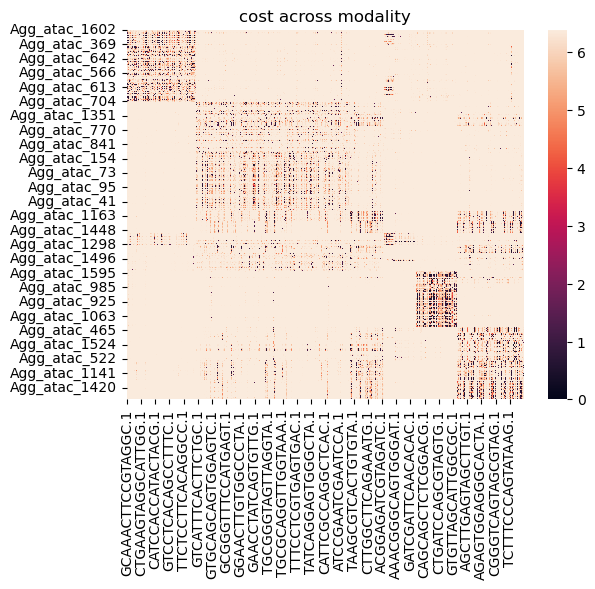

In [30]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
pl.title('cost across modality')

## scale

In [8]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [31]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, device='cuda:8',eps_p = 4e-2, rho_mu=100, rho_nu=100)

import pickle
with open('/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/P_tensor/P_tensor_aggBMMC_scVI.pickle', 'wb') as file:
    pickle.dump(P_tensor, file)

minibatch = 1 and device =  cuda:8
the total number of computing batch is  12


100%|██████████| 12/12 [1:26:07<00:00, 430.60s/it]


In [32]:
import torch
torch.cuda.empty_cache()

In [9]:
import pickle

# 从pickle文件读取数据
with open('/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/P_tensor/P_tensor_aggBMMC_scVI.pickle', 'rb') as file:
    P_tensor = pickle.load(file)

## make multi-omics alignment from the transport tensor

In [ ]:
P = fgot_tol(P_tensor)
P.shape

Text(0.5, 1.0, 'optimal transport matrix')

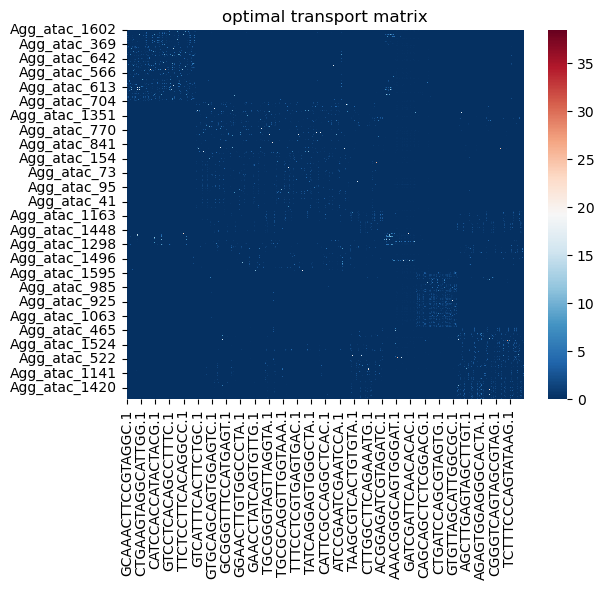

In [34]:
P_df = pd.DataFrame(P, index = cell_names1, columns = cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_P = P_df.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_P = sorted_P.iloc[:, sorted_rows]
sns.heatmap(sorted_P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [ ]:
X1_aligned, X2_aligned = align(X1, X2, P)

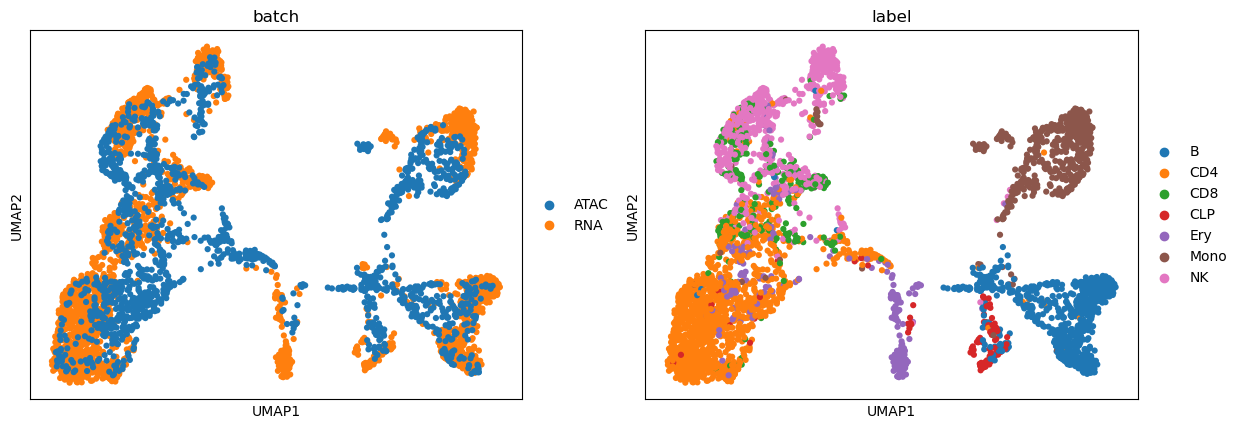

In [36]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)
pl.savefig("/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/pdf/aggBMMC_FGOT_scVI_align.pdf")

In [37]:
adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/scVI_result/aggBMMC_FGOT_scVI_adata.h5ad")

## infer the cell type specific regulatory intensity from the transport tensor

In [10]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

100%|██████████| 275/275 [03:02<00:00,  1.50it/s]


,CD4,NK,Mono,B,CD8,Ery,CLP
HCST-chr19-36400046-36400793,2.341198e-06,0.000002,6.258065e-05,5.131538e-06,0.000003,0.000000e+00,1.782386e-05
HCST-chr19-36504691-36505810,2.295262e-05,0.000026,1.211686e-06,1.428069e-06,0.000024,4.962188e-06,2.525936e-06
HCST-chr19-36359168-36359710,1.358452e-05,0.000052,1.374395e-05,1.288550e-06,0.000044,7.498218e-07,5.812761e-15
HCST-chr19-36238964-36239992,2.210159e-05,0.000033,8.851950e-07,1.318594e-06,0.000026,1.018930e-05,4.317801e-06
HCST-chr19-36246426-36246837,2.035011e-05,0.000013,1.780475e-05,8.306671e-07,0.000030,6.987738e-07,3.535508e-15
...,...,...,...,...,...,...,...
SNCA-chr4-90822975-90823353,1.707650e-06,0.000007,2.754558e-05,5.115339e-06,0.000000,5.396561e-04,5.058886e-15
SNCA-chr4-90850760-90851251,6.117067e-06,0.000006,1.829717e-06,5.008769e-06,0.000009,5.501480e-04,2.306666e-15
GYPB-chr4-144695106-144695549,5.867815e-06,0.000000,0.000000e+00,1.269339e-05,0.000000,1.231338e-03,2.461840e-04
GYPB-chr4-144833188-144833444,4.979411e-08,0.000000,0.000000e+00,6.705000e-06,0.000000,0.000000e+00,2.899482e-04


In [11]:
intensity_df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/scVI_result/aggBMMC_FGOT_scVI_regulation.txt') 

# Tutorial2: data integration for Agg_BMMC data (GLUE)

在聚合的BMMC数据（cells）上运行FGOT，其中cost的建立来自于多种sota的多组学整合方法。

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [3]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/BMMC_data/"
RNA_data = pd.read_csv(data_path+'RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'ATAC_normalized.txt', sep='\t', index_col=0)

In [4]:
RNA_cluster = pd.read_csv(data_path+"BMMC_RNA_label.txt", sep='\t')
ATAC_cluster = pd.read_csv(data_path+"BMMC_agg_k5_atac_label.txt", sep='\t')
RNA_cluster = RNA_cluster.reset_index()
RNA_cluster = RNA_cluster.rename(columns={'index':'cell','x': 'cluster'})
ATAC_cluster = ATAC_cluster.reset_index()
ATAC_cluster = ATAC_cluster.rename(columns={'index':'cell','metas': 'cluster'})

In [5]:
X1 = ATAC_data
X2 = RNA_data
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.index)
cell_names2 = list(RNA_data.index)
peak_names = list(ATAC_data.columns)
gene_names = list(RNA_data.columns)

Dimensions of input datasets are:  X1 =  (1602, 6970)  X2 =  (2379, 275)
Dimensions of basic_labels are:  basic_labels1 =  (1602,)  basic_labels2 =  (2379,)


## build a priori feature graph

In [6]:
promoters = pd.read_csv(data_path+'hg19.promoter.regions.txt', sep = '\t',header=None)
promoters[3] = promoters[3].str.split('|').str[0]
promoters.rename(columns={0: 'chr', 1: 'starts', 2: 'ends', 3: 'genes'}, inplace=True)
promoters.head()

,chr,starts,ends,genes
0,chr1,11869,11870,DDX11L1
1,chr1,11872,11873,DDX11L1
2,chr1,11874,11875,DDX11L1
3,chr1,12010,12011,DDX11L1
4,chr1,24886,24887,WASH7P


In [7]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

178865it [00:00, 359009.81it/s]
178865it [00:03, 53570.84it/s]
100%|██████████| 275/275 [00:00<00:00, 381.03it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 275 6970 8808


100%|██████████| 8808/8808 [00:00<00:00, 1704976.45it/s]


,TNFRSF25,EFHD2,RCAN3,LDLRAP1,STMN1,JUN,RHOC,CD2,CD160,MCL1,...,CLIC3,AP1S2,SAT1,CFP,PIM2,ALAS2,ITM2A,SH2D1A,CD40LG,MPP1
chr19-36400046-36400793,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-167479681-167479740,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr22-23062530-23064843,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr5-131720959-131721533,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-122326159-122327317,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr14-75760332-75763216,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-2819497-2820437,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-151893976-151894426,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr17-76272306-76272944,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

In [8]:
import anndata
file_path = "/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/"

In [9]:
adata_tmp = anndata.read(file_path + "GLUE_result/GLUE-combined.h5ad")
adata_tmp

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3981 × 0
    obs: 'cell_type', 'domain', 'balancing_weight'
    uns: 'cell_type_colors', 'domain_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_umap'
    obsp: 'connectivities', 'distances'

In [10]:
atac_emd = adata_tmp[adata_tmp.obs["domain"] == "scATAC-seq"].obsm["X_glue"]
rna_emd = adata_tmp[adata_tmp.obs["domain"] == "scRNA-seq"].obsm["X_glue"]
atac_emd.shape, rna_emd.shape

((1602, 50), (2379, 50))

In [11]:
S_m = pre.calculate_cell_similarity_byMNN(atac_emd, rna_emd, cell_names1, cell_names2, scale=0, knn = 40)
r = pre.check_mnn_accuracy(S_m, basic_labels1, basic_labels2)
print("The accuracy of identifying MNN pairs is:", r)

the number of MNN pairs is  42580
The accuracy of identifying MNN pairs is: 0.7879019831197421


In [12]:
# import snn
s_tmp = adata_tmp.obsp['connectivities'].toarray()
np.fill_diagonal(s_tmp, 1)
snn1 = s_tmp[n2:,n2:] # ATAC
snn2 = s_tmp[:n2,:n2] # RNA

In [13]:
S_sm = pre.smooth_cell_similarity_byLaplacian2(S_m,snn1,snn2)
S = S_sm/np.max(S_sm) + S_m/np.max(S_m)

In [14]:
cost = np.array(np.exp(np.max(S) - S))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

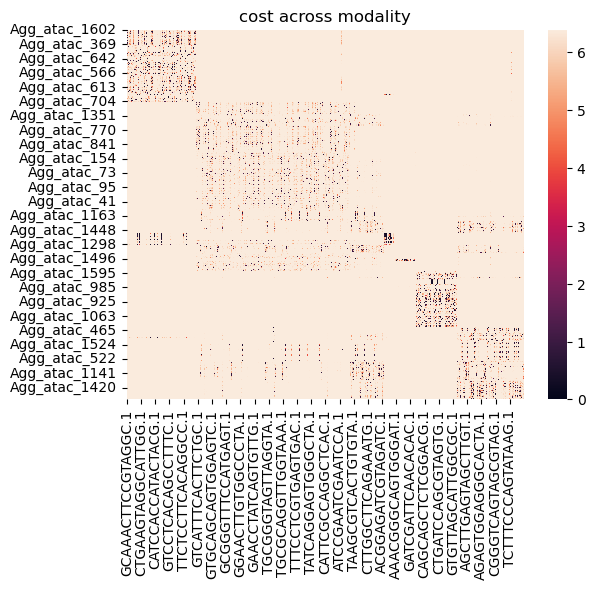

In [15]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
pl.title('cost across modality')

## scale

In [16]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [20]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, device='cuda:2',eps_p = 4e-2, rho_mu=100, rho_nu=100)

import pickle
with open('/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/P_tensor/P_tensor_aggBMMC_GLUE.pickle', 'wb') as file:
    pickle.dump(P_tensor, file)

minibatch = 1 and device =  cuda:2
the total number of computing batch is  12





 17%|█▋        | 2/12 [33:20<2:46:43, 1000.37s/it]










100%|██████████| 12/12 [1:16:31<00:00, 382.66s/it]


In [21]:
import torch
torch.cuda.empty_cache()

In [13]:
import pickle

# 从pickle文件读取数据
with open('/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/P_tensor/P_tensor_aggBMMC_GLUE.pickle', 'rb') as file:
    P_tensor = pickle.load(file)

## make multi-omics alignment from the transport tensor

In [23]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 8808/8808 [01:00<00:00, 145.28it/s]


(1602, 2379)

Text(0.5, 1.0, 'optimal transport matrix')

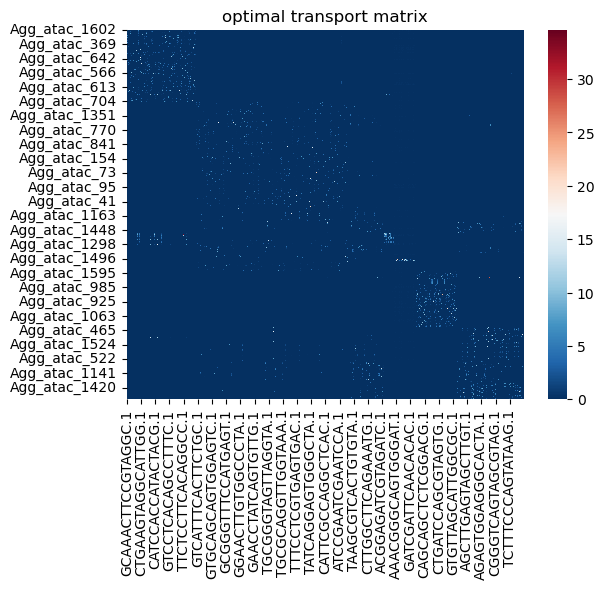

In [24]:
P_df = pd.DataFrame(P, index = cell_names1, columns = cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_P = P_df.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_P = sorted_P.iloc[:, sorted_rows]
sns.heatmap(sorted_P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [25]:
X1_aligned, X2_aligned = align(X1, X2, P)

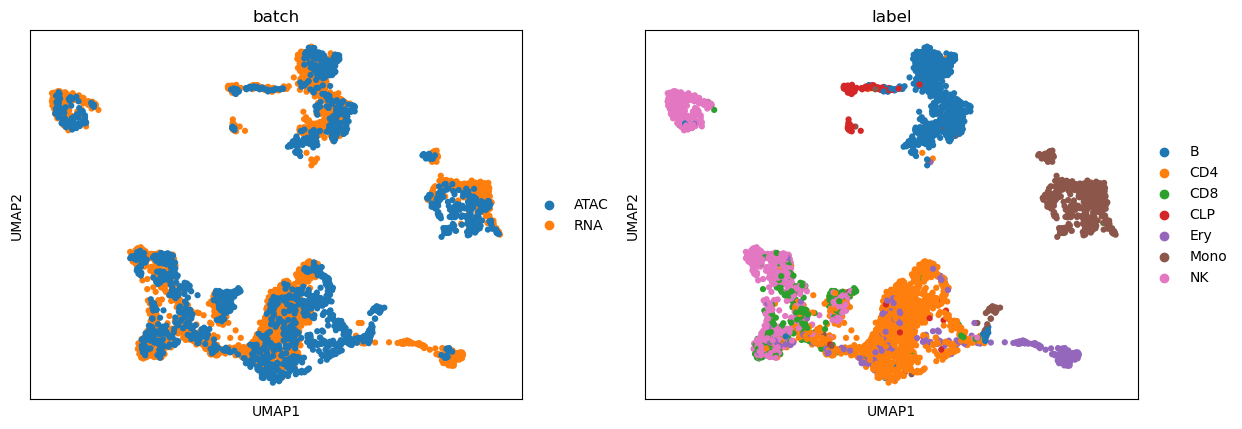

In [26]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)
pl.savefig("/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/pdf/aggBMMC_FGOT_GLUE_align.pdf")

In [27]:
adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/GLUE_result/aggBMMC_FGOT_GLUE_adata.h5ad")

## infer the cell type specific regulatory intensity from the transport tensor

In [14]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

100%|██████████| 275/275 [03:03<00:00,  1.50it/s]


,CD4,NK,Mono,B,CD8,Ery,CLP
HCST-chr19-36400046-36400793,2.025435e-06,0.000002,8.714356e-05,3.350719e-06,0.000004,0.000000e+00,7.980972e-05
HCST-chr19-36504691-36505810,2.624881e-05,0.000028,1.637910e-06,2.428391e-06,0.000028,1.314683e-05,1.308885e-05
HCST-chr19-36359168-36359710,1.435181e-05,0.000058,1.619985e-05,8.836784e-07,0.000057,6.790250e-06,6.239408e-06
HCST-chr19-36238964-36239992,2.611871e-05,0.000037,1.486698e-06,2.059242e-06,0.000031,4.145813e-05,1.229486e-05
HCST-chr19-36246426-36246837,1.872706e-05,0.000015,2.494067e-05,1.211630e-06,0.000026,3.844309e-07,7.493090e-06
...,...,...,...,...,...,...,...
SNCA-chr4-90822975-90823353,2.440881e-06,0.000004,1.717580e-05,2.397238e-06,0.000000,4.983629e-04,9.215270e-07
SNCA-chr4-90850760-90851251,3.713559e-06,0.000002,9.308739e-08,1.870792e-06,0.000005,5.328991e-04,2.410338e-07
GYPB-chr4-144695106-144695549,5.094131e-06,0.000000,0.000000e+00,1.758764e-05,0.000000,1.353376e-03,5.593407e-05
GYPB-chr4-144833188-144833444,3.887271e-25,0.000000,0.000000e+00,9.530500e-27,0.000000,0.000000e+00,4.663606e-38


In [15]:
intensity_df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_BMMC/BMMC_in_scVI_GLUE/GLUE_result/aggBMMC_FGOT_GLUE_regulation.txt') 